<a href="https://colab.research.google.com/github/abhiyantaabhishek/COVID_19_Detection/blob/master/COVID_19_Detection_DenseNet201.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
import PIL
from PIL import Image

In [4]:
!git clone https://github.com/abhiyantaabhishek/COVID_19_Detection
%cd COVID_19_Detection

Cloning into 'COVID_19_Detection'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 783 (delta 11), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (783/783), 93.68 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/COVID_19_Detection


In [347]:
CT_COVID = ['CT_COVID/'+f for f in  os.listdir('CT_COVID')]
CT_NonCOVID = ['CT_NonCOVID/'+f for f in  os.listdir('CT_NonCOVID')]

In [348]:
Data_img = []
label = []
for f in CT_COVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(1)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(1)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  label.append(1)
  image=np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())

for f in CT_NonCOVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(0)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(0)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  label.append(0)
  image=np.array(image)  
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
Data_img=np.array(Data_img)
label=np.array(label)


In [349]:
index = np.array(list(range(len(Data_img))))
np.random.shuffle(index)
data_train_x  = Data_img[index[:int(len(index)*0.6)]]
data_val_x = Data_img[index[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]]
data_test_x = Data_img[index[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]]

data_train_y  = label[index[:int(len(index)*0.6)]]
data_val_y = label[index[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]]
data_test_y = label[index[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]]

In [350]:
raw_train = tf.data.Dataset.from_tensor_slices((data_train_x, data_train_y))
raw_validation = tf.data.Dataset.from_tensor_slices((data_val_x, data_val_y))
raw_test = tf.data.Dataset.from_tensor_slices((data_test_x, data_test_y))

In [351]:
class_names = ['COVID_Negative','COVID_Positive']

In [352]:
print(raw_train)
print(raw_validation)
print(raw_test)

<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>
<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>
<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>


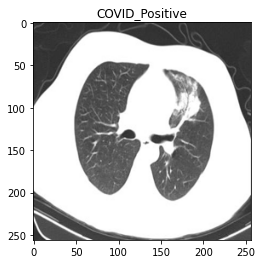

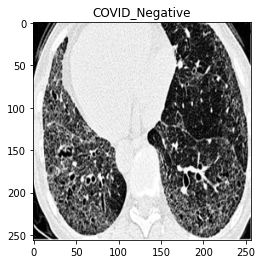

In [353]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[label])

In [354]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [355]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [356]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [357]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [358]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [359]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [360]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1920)


In [361]:
base_model.trainable = False

In [362]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 166, 166, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [363]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


In [364]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [365]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [366]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [367]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1920)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [368]:
len(model.trainable_variables)

2

In [369]:
initial_epochs = 20
validation_steps=np.floor(len(data_val_x) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

13/13 [==============================] - 1s 57ms/step - loss: 0.7854 - accuracy: 0.5024


In [370]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.50


In [371]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
42/42 [==============================] - 4s 95ms/step - loss: 0.7485 - accuracy: 0.5052 - val_loss: 0.7253 - val_accuracy: 0.4966
Epoch 2/20
42/42 [==============================] - 4s 94ms/step - loss: 0.7072 - accuracy: 0.5455 - val_loss: 0.6907 - val_accuracy: 0.5548
Epoch 3/20
42/42 [==============================] - 4s 93ms/step - loss: 0.6759 - accuracy: 0.5842 - val_loss: 0.6619 - val_accuracy: 0.5951
Epoch 4/20
42/42 [==============================] - 4s 94ms/step - loss: 0.6490 - accuracy: 0.6110 - val_loss: 0.6385 - val_accuracy: 0.6242
Epoch 5/20
42/42 [==============================] - 4s 95ms/step - loss: 0.6287 - accuracy: 0.6483 - val_loss: 0.6162 - val_accuracy: 0.6532
Epoch 6/20
42/42 [==============================] - 4s 94ms/step - loss: 0.6083 - accuracy: 0.6669 - val_loss: 0.5970 - val_accuracy: 0.6801
Epoch 7/20
42/42 [==============================] - 4s 94ms/step - loss: 0.5898 - accuracy: 0.6870 - val_loss: 0.5839 - val_accuracy: 0.7047
Epoch 8/20
42

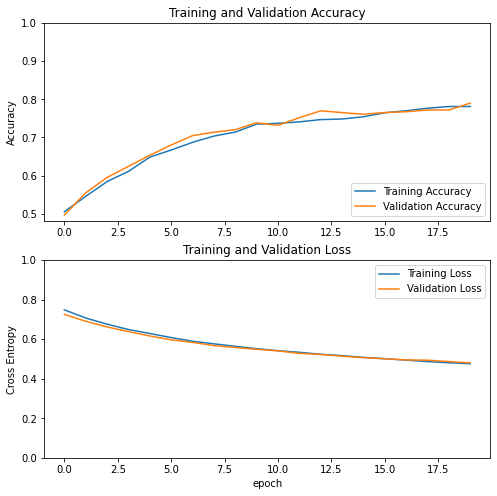

In [372]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [373]:
base_model.trainable = True

In [374]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [375]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [376]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1920)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,076,993
Non-trainable params: 246,912
_________________________________________________________________


In [377]:
len(model.trainable_variables)

598

In [378]:
fine_tune_epochs =22
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/42
42/42 [==============================] - 13s 318ms/step - loss: 0.6034 - accuracy: 0.6654 - val_loss: 0.4383 - val_accuracy: 0.7942
Epoch 21/42
42/42 [==============================] - 10s 235ms/step - loss: 0.3203 - accuracy: 0.8815 - val_loss: 0.4456 - val_accuracy: 0.7919
Epoch 22/42
42/42 [==============================] - 10s 235ms/step - loss: 0.1827 - accuracy: 0.9680 - val_loss: 0.3999 - val_accuracy: 0.8300
Epoch 23/42
42/42 [==============================] - 10s 236ms/step - loss: 0.1009 - accuracy: 0.9940 - val_loss: 0.3623 - val_accuracy: 0.8434
Epoch 24/42
42/42 [==============================] - 10s 235ms/step - loss: 0.0541 - accuracy: 0.9985 - val_loss: 0.2958 - val_accuracy: 0.8747
Epoch 25/42
42/42 [==============================] - 10s 235ms/step - loss: 0.0330 - accuracy: 0.9985 - val_loss: 0.2447 - val_accuracy: 0.9060
Epoch 26/42
42/42 [==============================] - 10s 235ms/step - loss: 0.0216 - accuracy: 0.9993 - val_loss: 0.2232 - val_accuracy:

In [379]:
validation_steps=np.floor(len(data_val_x) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("Final Validation loss: {:.2f}".format(loss0))
print("Final Validation accuracy: {:.2f}".format(accuracy0))

13/13 [==============================] - 1s 56ms/step - loss: 0.2682 - accuracy: 0.9399
Final Validation loss: 0.27
Final Validation accuracy: 0.94


In [380]:
test_steps=np.floor(len(data_test_x) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(test_batches, steps = test_steps)
print("Final test loss: {:.2f}".format(loss0))
print("Final test accuracy: {:.2f}".format(accuracy0))

13/13 [==============================] - 1s 56ms/step - loss: 0.2272 - accuracy: 0.9399
Final test loss: 0.23
Final test accuracy: 0.94


In [381]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

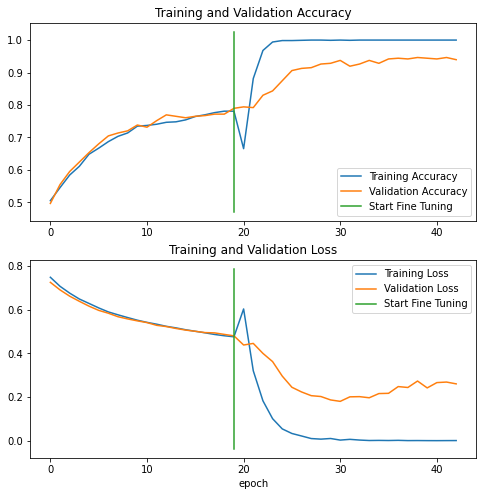

In [382]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 1)

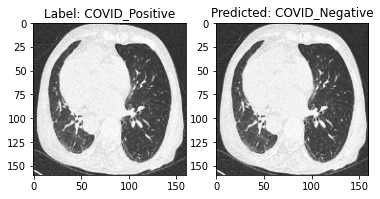

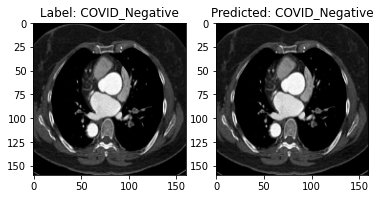

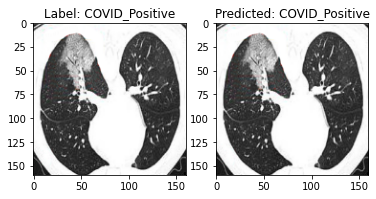

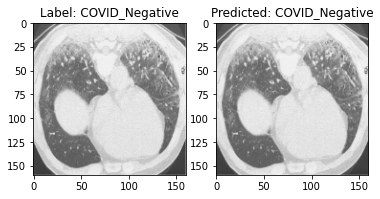

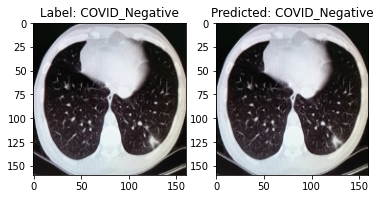

In [383]:
for image_batch, label_batch in test_batches.take(5):
  image_batch_to_show = np.array(((image_batch.numpy()+1)*127.5),dtype=np.uint8)
  predictions = model.predict(image_batch)
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(image_batch_to_show[0])
  plt.title('Label: '+class_names[int(label_batch[0])])    
  plt.subplot(1, 2, 2)
  plt.imshow(image_batch_to_show[0])
  plt.title('Predicted: '+class_names[int(predictions[0]>0.5)])

predictions.shape